[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/pytorch/rl/blob/main/tutorials/coding_ddpg.ipynb)

# Coding DDPG using TorchRL

This tutorial will guide you through the steps to code DDPG from scratch.
DDPG ([Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971)) is a simple continuous control algorithm. It essentially consists in learning a parametric value function for an action-observation pair, and then learning a policy that outputs actions that maximise this value function given a certain observation.

In this tutorial, you will learn:
- how to build an environment in TorchRL, including transforms (e.g. data normalization) and parallel execution;
- how to design a policy and value network;
- how to collect data from your environment efficiently and store them in a replay buffer;
- how to store trajectories (and not transitions) in your replay buffer);
- and finally how to evaluate your model.

This tutorial assumes the reader is familiar with some of TorchRL primitives, such as `TensorDict` and `TensorDictModules`, although it should be sufficiently transparent to be understood without a deep understanding of these classes.

We do not aim at giving a SOTA implementation of the algorithm, but rather to provide a high-level illustration of TorchRL features in the context of this algorithm.

In [ ]:
!pip install functorch
!pip install "gym[classic_control]"
!pip install dm_control matplotlib tqdm
!pip install torchrl

In [1]:
# Make all the necessary imports for training

from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.cuda
import tqdm
from matplotlib import pyplot as plt
from torch import nn
from torch import optim

from torchrl.collectors import MultiaSyncDataCollector
from torchrl.data import CompositeSpec
from torchrl.data import (
    TensorDictPrioritizedReplayBuffer,
    TensorDictReplayBuffer,
)
from torchrl.data.postprocs import MultiStep
from torchrl.data.replay_buffers.storages import LazyMemmapStorage
from torchrl.envs import (
    ParallelEnv,
    EnvCreator,
    CatTensors,
    ObservationNorm,
    DoubleToFloat,
)
from torchrl.envs.libs.dm_control import DMControlEnv
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.transforms import RewardScaling, TransformedEnv
from torchrl.envs.utils import set_exploration_mode, step_mdp
from torchrl.modules import (
    OrnsteinUhlenbeckProcessWrapper,
    MLP,
    TensorDictModule,
    ProbabilisticActor,
    ValueOperator,
)
from torchrl.modules.distributions.continuous import TanhDelta
from torchrl.objectives.utils import hold_out_net
from torchrl.trainers import Recorder
from torchrl.trainers.helpers.envs import (
    get_stats_random_rollout,
)


# Environment

Let us start by building the environment.

For this example, we will be using the cheetah task. The goal is to make a half-cheetah run as fast as possible.

In TorchRL, one can create such a task by relying on dm_control or gym:

```python
env = GymEnv("HalfCheetah-v4")
```

or

```python
env = DMControlEnv("cheetah", "run")
```

We only consider the state-based environment, but if one wishes to use a pixel-based environment, this can be done via the keyword argument `from_pixels=True` which is passed when calling `GymEnv` or `DMControlEnv`.

In [2]:
def make_env():
    """
    Create a base env
    """
    global env_library
    global env_name

    if backend == "dm_control":
        env_name = "cheetah"
        env_task = "run"
        env_args = (env_name, env_task)
        env_library = DMControlEnv
    elif backend == "gym":
        env_name = "HalfCheetah-v4"
        env_args = (env_name, )
        env_library = GymEnv
    else:
        raise NotImplementedError
        

    env_kwargs = {
        "device": device,
        "frame_skip": frame_skip,
        "from_pixels": from_pixels,
        "pixels_only": from_pixels,
    }
    env = env_library(*env_args, **env_kwargs)
    return env


## Transforms

Now that we have a base environment, we may want to modify its representation to make it more policy-friendly.

It is common in DDPG to rescale the reward using some heuristic value. We will multiply the reward by 5 in this example.

If we are using dm_control, it is important also to transform the actions to double precision numbers as this is the dtype expected by the library.

We also leave the possibility to normalize the states: we will take care of computing the normalizing constants later on.

In [3]:

def make_transformed_env(
    env, stats=None,
):
    """
    Apply transforms to the env (such as reward scaling and state normalization)
    """

    env = TransformedEnv(env)
    
    # we append transforms one by one, although we might as well create the transformed environment using the `env = TransformedEnv(base_env, transforms)` syntax.
    env.append_transform(RewardScaling(loc=0.0, scale=reward_scaling))

    double_to_float_list = []
    double_to_float_inv_list = []
    if env_library is DMControlEnv:
        # DMControl requires double-precision
        double_to_float_list += [
            "reward",
        ]
        double_to_float_inv_list += ["action"]
    
    
    # We concatenate all states into a single "next_observation_vector"
    # even if there is a single tensor, it'll be renamed in "next_observation_vector". 
    # This facilitates the downstream operations as we know the name of the output tensor.
    # In some environments (not half-cheetah), there may be more than one observation vector: in this case this code snippet will concatenate them all.
    selected_keys = list(env.observation_spec.keys())
    out_key = "next_observation_vector"
    env.append_transform(CatTensors(keys_in=selected_keys, out_key=out_key))

    #  we normalize the states
    if stats is None:
        _stats = {"loc": 0.0, "scale": 1.0}
    else:
        _stats = stats
    env.append_transform(
        ObservationNorm(**_stats, keys_in=[out_key], standard_normal=True)
    )

    double_to_float_list.append(out_key)
    env.append_transform(
        DoubleToFloat(
            keys_in=double_to_float_list, keys_inv_in=double_to_float_inv_list
        )
    )

    
    return env


## Parallel execution

The following helper function allows us to run environments in parallel. One can choose between running each base env in a separate process and execute the transform in the main process, or execute the transforms in parallel.
To leverage the vectorization capabilities of PyTorch, we adopt the first method:

In [4]:
def parallel_env_constructor(
    stats,
    **env_kwargs,
):
    if env_per_collector == 1:
        env_creator = EnvCreator(
            lambda: make_transformed_env(make_env(), stats, **env_kwargs)
        )
        return env_creator

    parallel_env = ParallelEnv(
        num_workers=env_per_collector,
        create_env_fn=EnvCreator(lambda: make_env()),
        create_env_kwargs=None,
        pin_memory=False,
    )
    env = make_transformed_env(parallel_env, stats, **env_kwargs)
    return env



# Normalization of the observations

To compute the normalizing statistics, we run an arbitrary number of random steps in the environment and compute the mean and standard deviation of the collected observations:

In [5]:
def get_stats_random_rollout(
    proof_environment, key: Optional[str] = None
):
    print("computing state stats")
    n = 0
    td_stats = []
    while n < init_env_steps:
        _td_stats = proof_environment.rollout(max_steps=init_env_steps)
        n += _td_stats.numel()
        _td_stats_select = _td_stats.to_tensordict().select(key).cpu()
        if not len(list(_td_stats_select.keys())):
            raise RuntimeError(
                f"key {key} not found in tensordict with keys {list(_td_stats.keys())}"
            )
        td_stats.append(_td_stats_select)
        del _td_stats, _td_stats_select
    td_stats = torch.cat(td_stats, 0)

    if key is None:
        keyset_seedlist(proof_environment.observation_spec.keys())
        key = keys.pop()
        if len(keys):
            raise RuntimeError(
                f"More than one key exists in the observation_specs: {[key] + keys} were found, "
                "thus get_stats_random_rollout cannot infer which to compute the stats of."
            )

    m = td_stats.get(key).mean(dim=0)
    s = td_stats.get(key).std(dim=0)
    m[s == 0] = 0.0
    s[s == 0] = 1.0

    print(
        f"stats computed for {td_stats.numel()} steps. Got: \n"
        f"loc = {m}, \n"
        f"scale: {s}"
    )
    if not torch.isfinite(m).all():
        raise RuntimeError("non-finite values found in mean")
    if not torch.isfinite(s).all():
        raise RuntimeError("non-finite values found in sd")
    stats = {"loc": m, "scale": s}
    return stats


def get_env_stats():
    """
    Gets the stats of an environment
    """
    proof_env = make_transformed_env(make_env(), None)
    proof_env.set_seed(seed)
    stats = get_stats_random_rollout(
        proof_env, key="next_observation_vector",
    )
    # make sure proof_env is closed
    proof_env.close()
    return stats


# Building the model

Let us now build the DDPG actor and QValue network.

In [6]:
def make_ddpg_actor(
    stats,
    device="cpu",
):
    proof_environment = make_transformed_env(make_env(), stats)


    env_specs = proof_environment.specs
    out_features = env_specs["action_spec"].shape[0]

    actor_net = MLP(
        num_cells=[num_cells] * num_layers,
        activation_class=nn.Tanh,
        out_features=out_features,
    )
    in_keys = ["observation_vector"]
    out_keys = ["param"]

    actor_module = TensorDictModule(actor_net, in_keys=in_keys, out_keys=out_keys)

    # We use a ProbabilisticActor to make sure that we map the network output
    # to the right space using a TanhDelta distribution.
    actor = ProbabilisticActor(
        module=actor_module,
        dist_param_keys=["param"],
        spec=CompositeSpec(action=env_specs["action_spec"]),
        safe=True,
        distribution_class=TanhDelta,
        distribution_kwargs={
            "min": env_specs["action_spec"].space.minimum,
            "max": env_specs["action_spec"].space.maximum,
        },
    ).to(device)

    q_net = MLP(
        num_cells=[num_cells] * num_layers,
        activation_class=nn.Tanh,
        out_features=1,
    )

    in_keys = in_keys + ["action"]
    qnet = ValueOperator(
        in_keys=in_keys,
        module=q_net,
    ).to(device)

    # init: since we have lazy layers, we should run the network once to initialize them
    with torch.no_grad(), set_exploration_mode("random"):
        td = proof_environment.rollout(max_steps=1000)
        td = td.to(device)
        actor(td)
        qnet(td)

    return actor, qnet



# Evaluator: building your recorder object

As the training data is obtained using some exploration strategy, the true performance of our algorithm needs to be assessed in deterministic mode. We do this using a dedicated class, `Recorder`, which executes the policy in the environment at a given frequency and returns some statistics obtained from these simulations.
The following helper function builds this object:

In [7]:
def make_recorder(actor_model_explore, stats):
    base_env = make_env()
    recorder = make_transformed_env(base_env, stats)
    
    recorder_obj = Recorder(
        record_frames=1000,
        frame_skip=frame_skip,
        policy_exploration=actor_model_explore,
        recorder=recorder,
        exploration_mode="mean",
        record_interval=record_interval,
    )
    return recorder_obj


# Replay buffer

Replay buffers come in two flavours: prioritized (where some error signal is used to give a higher likelihood of sampling to some items than others) and regular, circular experience replay.

We also provide a special storage, names LazyMemmapStorage, that will store tensors on physical memory using a memory-mapped array. The following function takes care of creating the replay buffer with the desired hyperparameters:

In [8]:
def make_replay_buffer(make_replay_buffer=3):
    if prb:
        replay_buffer = TensorDictPrioritizedReplayBuffer(
                buffer_size,
                alpha=0.7,
                beta=0.5,
                collate_fn=lambda x: x,
                pin_memory=False,
                prefetch=make_replay_buffer,
                storage=LazyMemmapStorage(
                    buffer_size,
                    scratch_dir=buffer_scratch_dir,
                    device=device,
                ),
            )
    else:
        replay_buffer = TensorDictReplayBuffer(
                buffer_size,
                collate_fn=lambda x: x,
                pin_memory=False,
                prefetch=make_replay_buffer,
                storage=LazyMemmapStorage(
                    buffer_size,
                    scratch_dir=buffer_scratch_dir,
                    device=device,
                ),
            )
    return replay_buffer

# Hyperparameters
After having written all our helper functions, it is now time to set the experiment hyperparameters:

In [9]:
backend = "dm_control"  # or "gym" 
frame_skip = 2  # if this value is changed, the number of frames collected etc. need to be adjusted
from_pixels = False
reward_scaling = 5.0

# execute on cuda if available
device = (
    torch.device("cpu")
    if torch.cuda.device_count() == 0
    else torch.device("cuda:0")
)

init_env_steps = 1000  # number of random steps used as for stats computation
env_per_collector = 2  # number of environments in each data collector

env_library = None  # overwritten because global in env maker
env_name = None  # overwritten because global in env maker

exp_name = "cheetah"
annealing_frames = 1000000 // frame_skip  # Number of frames before OU noise becomes null
lr=5e-4
weight_decay = 0.0
total_frames = 1000000 // frame_skip
init_random_frames = 5000 // frame_skip   # Number of random frames used as warm-up
optim_steps_per_batch = 32  # Number of iterations of the inner loop
batch_size = 128
frames_per_batch = 1000 // frame_skip    # Number of frames returned by the collector at each iteration of the outer loop
gamma = 0.99
tau = 0.005    # Decay factor for the target network
prb = True    # If True, a Prioritized replay buffer will be used
buffer_size = 1000000 // frame_skip    # Number of frames stored in the buffer
buffer_scratch_dir = "/tmp/"
n_steps_forward = 3

record_interval = 10  # record every 10 batch collected

# Network specs
num_cells = 64
num_layers = 2

seed = 0

# Initialization
To initialize the experiment, we first acquire the observation statistics, then build the networks, wrap them in an exploration wrapper (following the seminal DDPG paper, we used an Ornstein-Uhlenbeck process to add noise to the sampled actions).

In [10]:
torch.manual_seed(0)
np.random.seed(0)

# get stats for normalization
stats = get_env_stats()

# Actor and qnet instantiation
actor, qnet = make_ddpg_actor(
    stats=stats,
    device=device,
)
if device == torch.device("cpu"):
    actor.share_memory()
# Target network
qnet_target = deepcopy(qnet).requires_grad_(False)

# Exploration wrappers:
actor_model_explore = OrnsteinUhlenbeckProcessWrapper(
    actor,
    annealing_num_steps=annealing_frames,
).to(device)
if device == torch.device("cpu"):
    actor_model_explore.share_memory()

# Environment setting:
create_env_fn = parallel_env_constructor(
    stats=stats,
)


computing state stats
stats computed for 1000 steps. Got: 
loc = tensor([-0.1162,  0.0583,  0.0144,  0.0348, -0.0349, -0.0851, -0.1215, -0.1039,
        -0.1680,  0.0027, -0.0008,  0.0243,  0.0047, -0.0121, -0.0219, -0.0045,
        -0.0048]), 
scale: tensor([0.0321, 0.0595, 0.1625, 0.1695, 0.1758, 0.1003, 0.1615, 0.1825, 0.4745,
        0.4449, 1.1256, 3.8970, 4.9873, 5.0538, 2.6160, 3.8959, 4.0352])


/Users/vmoens/venv/rl/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Data collector

Creating the data collector is a crucial step in an RL experiment.
TorchRL provides a couple of classes to collect data in parallel. Here we will use `MultiaSyncDataCollector`, a data collector that will be executed in an async manner (i.e. data will be collected while the policy is being optimized).

The parameters to specify are: the list of environment creation functions, the policy, the total number of frames before the collector is considered empty, the maximum number of frames per trajectory (useful for non-terminating environments, like dm_control ones).
One should also pass the number of frames in each batch collected, the number of random steps executed independently from the policy, the devices used for policy execution and data transmission.

The `MultiStep` object passed as postproc makes it so that the rewards of the n upcoming steps are added (with some discount factor) and the next observation is changed to be the n-step forward observation.

In [11]:
# Batch collector:
collector = MultiaSyncDataCollector(
    create_env_fn=[create_env_fn, create_env_fn],
    policy = actor_model_explore,
    total_frames = total_frames,
    max_frames_per_traj = 1000,
    frames_per_batch = frames_per_batch,
    init_random_frames = init_random_frames,
    reset_at_each_iter = False,
    postproc = MultiStep(n_steps_max=n_steps_forward, gamma=gamma) if n_steps_forward > 0 else None,
    split_trajs = True,
    devices = [device, device],  # device for execution
    passing_devices = [device, device],  # device where data will be stored and passed
    seed = None,
    pin_memory = False,
    update_at_each_batch = False,
    exploration_mode = "random",
)
collector.set_seed(seed)

3018685293

We can now create the replay buffer as part of the initialization

In [12]:
# Replay buffer:
replay_buffer = make_replay_buffer()

# trajectory recorder
recorder = make_recorder(actor_model_explore, stats)

Finally, we will use the Adam optimizer for the policy and value network, with the same learning rate for both.

In [13]:
# Optimizers
optimizer_actor = optim.Adam(
    actor.parameters(), lr=lr, weight_decay=weight_decay
)
optimizer_qnet = optim.Adam(
    qnet.parameters(), lr=lr, weight_decay=weight_decay
)
total_collection_steps = total_frames // frames_per_batch

scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_actor, T_max=total_collection_steps)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_qnet, T_max=total_collection_steps)


# Time to train the policy!

Some notes about the following cell:
- `hold_out_net` is a TorchRL context manager that temporarily sets requires_grad to False for a set of network parameters. This is used to prevent `backward` to write gradients on parameters that need not to be differentiated given the loss at hand.
- The value network is designed using the `ValueOperator` TensorDictModule subclass. This class will write a `"state_action_value"` if one of its `in_keys` is named "action", otherwise it will assume that only the state-value is returned and the output key will simply be `"state_value"`. In the case of DDPG, the value if of the state-action pair, hence the first name is used.
- The `step_mdp` helper function returns a new TensorDict that essentially does the `obs = next_obs`. In other words, it will return a new tensordict where the values that are related to the next state (next observations of various type) are selected and written as if they were current. This makes it possible to pass this new tensordict to the policy or value network (which expects an `"observation_vector"` key, not `"next_observation_vector"`.
- When using prioritized replay buffer, a priority key is added to the sampled tensordict (named `"td_error"` by default). Then, this TensorDict will be fed back to the replay buffer using the `update_priority` method. Under the hood, this method will read the index present in the TensorDict as well as the priority value, and update its list of priorities at these indices.
- TorchRL provides optimized versions of the loss functions (such as this one) where one only needs to pass a sampled tensordict and obtains a dictionary of losses and metadata in return (see `torchrl.objectives` for more context). Here we write the full loss function in the optimization loop for transparency. Similarly, the target network updates are written explicitely but TorchRL provides a couple of dedicated classes for this (see `torchrl.objectives.SoftUpdate` and `torchrl.objectives.HardUpdate`).
- After each collection of data, we call `collector.update_policy_weights_()`, which will update the policy network weights on the data collector. If the code is executed on cpu or with a single cuda device, this part can be ommited. If the collector is executed on another device, then its weights must be synced with those on the main, training process and this method should be incorporated in the training loop (ideally early in the loop in async settings, and at the end of it in sync settings).

In [14]:
rewards = []
rewards_eval = []

# Main loop
norm_factor_training = sum(gamma**i for i in range(n_steps_forward)) if n_steps_forward else 1

collected_frames = 0
pbar = tqdm.tqdm(total=total_frames)
r0 = None
for i, tensordict in enumerate(collector):

    # update weights of the inference policy
    collector.update_policy_weights_()
    
    if r0 is None:
        r0 = tensordict["reward"].mean().item()
    pbar.update(tensordict.numel())
    
    # extend the replay buffer with the new data
    if "mask" in tensordict.keys():
        # if multi-step, a mask is present to help filter padded values
        current_frames = tensordict["mask"].sum()
        tensordict = tensordict[tensordict.get("mask").squeeze(-1)]
    else:
        tensordict = tensordict.view(-1)
        current_frames = tensordict.numel()
    collected_frames += current_frames
    replay_buffer.extend(tensordict.cpu())

    # optimization steps
    if collected_frames >= init_random_frames:
        for j in range(optim_steps_per_batch):
            # sample from replay buffer
            sampled_tensordict = replay_buffer.sample(batch_size)

            # compute loss for qnet and backprop
            with hold_out_net(actor):
                # get next state value
                next_tensordict = step_mdp(sampled_tensordict)
                qnet_target(actor(next_tensordict))
                next_value = next_tensordict["state_action_value"]
                assert not next_value.requires_grad
            value_est = (
                sampled_tensordict["reward"]
                + gamma * (1 - sampled_tensordict["done"].float()) * next_value
            )
            value = qnet(sampled_tensordict)["state_action_value"]
            value_loss = (value - value_est).pow(2).mean()
            # we write the td_error in the sampled_tensordict for priority update
            # because the indices of the samples is tracked in sampled_tensordict
            # and the replay buffer will know which priorities to update.
            sampled_tensordict["td_error"] = (value - value_est).pow(2).detach()
            value_loss.backward()
            
            optimizer_qnet.step()
            optimizer_qnet.zero_grad()

            # compute loss for actor and backprop: the actor must maximise the state-action value, hence the loss is the neg value of this.
            sampled_tensordict_actor = sampled_tensordict.select(*actor.in_keys)
            with hold_out_net(qnet):
                qnet(actor(sampled_tensordict_actor))
            actor_loss = -sampled_tensordict_actor["state_action_value"]
            actor_loss.mean().backward()

            optimizer_actor.step()
            optimizer_actor.zero_grad()

            # update qnet_target params
            for (p_in, p_dest) in zip(qnet.parameters(), qnet_target.parameters()):
                p_dest.data.copy_(tau * p_in.data + (1 - tau) * p_dest.data)
            for (b_in, b_dest) in zip(qnet.buffers(), qnet_target.buffers()):
                b_dest.data.copy_(tau * b_in.data + (1 - tau) * b_dest.data)

            # update priority
            if prb:
                replay_buffer.update_priority(sampled_tensordict)

    rewards.append((i, tensordict['reward'].mean().item() / norm_factor_training / frame_skip))
    td_record = recorder(None)
    if td_record is not None:
        rewards_eval.append((i, td_record["r_evaluation"]))
    if len(rewards_eval):
        pbar.set_description(f"reward: {rewards[-1][1]: 4.4f} (r0 = {r0: 4.4f}), reward eval: reward: {rewards_eval[-1][1]: 4.4f}")

    # update the exploration strategy
    actor_model_explore.step(current_frames)
    if collected_frames >= init_random_frames:
        scheduler1.step()
        scheduler2.step()

collector.shutdown()

  0%|▏                                                                                                                                                                                                                  | 500/500000 [00:00<10:41, 778.65it/s]

Creating a MemmapStorage...
The storage is being created: 
	done: /tmp/4phaxkx2, 0.476837158203125 Mb of storage (size: [500000, 1]).
	observation_vector: /tmp/abd9kbth, 32.4249267578125 Mb of storage (size: [500000, 17]).
	traj_ids: /tmp/ut1pard2, 3.814697265625 Mb of storage (size: [500000, 1]).
	step_count: /tmp/hb9gzrc2, 1.9073486328125 Mb of storage (size: [500000, 1]).
	action: /tmp/o8uv2l_9, 11.444091796875 Mb of storage (size: [500000, 6]).
	next_observation_vector: /tmp/ml8yh3kl, 32.4249267578125 Mb of storage (size: [500000, 17]).
	mask: /tmp/dfn8t1vs, 0.476837158203125 Mb of storage (size: [500000, 1]).
	gamma: /tmp/xezrkyok, 1.9073486328125 Mb of storage (size: [500000, 1]).
	steps_to_next_obs: /tmp/p8h4c098, 3.814697265625 Mb of storage (size: [500000, 1]).
	nonterminal: /tmp/rm4y1d1g, 0.476837158203125 Mb of storage (size: [500000, 1]).
	original_reward: /tmp/uwhmiv0w, 1.9073486328125 Mb of storage (size: [500000, 1]).
	reward: /tmp/ua2mtbrr, 1.9073486328125 Mb of storage

reward:  0.8416 (r0 =  0.2384), reward eval: reward:  0.6735: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [10:46<00:00, 916.85it/s]

# Experiment results
We make a simple plot of the average rewards during training. We can observe that our policy learned quite well to solve the task.

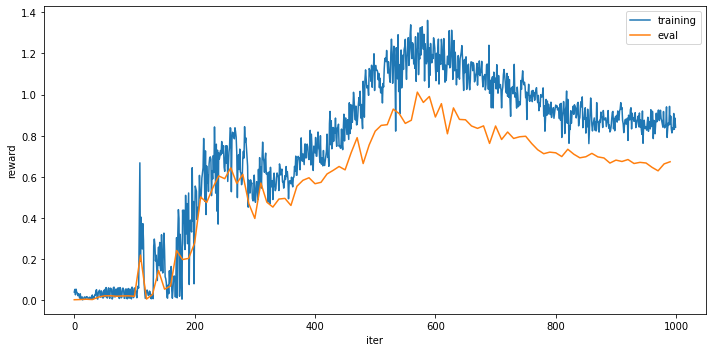

reward:  0.8416 (r0 =  0.2384), reward eval: reward:  0.6735: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [11:00<00:00, 916.85it/s]

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*rewards), label="training")
plt.plot(*zip(*rewards_eval), label="eval")
plt.legend()
plt.xlabel("iter")
plt.ylabel("reward")
plt.tight_layout()

# Sampling trajectories and using TD(lambda)
TD(lambda) is known to be less biased than the regular TD-error we used in the previous example.
To use it, however, we need to sample trajectories and not single transitions.

We modify the previous example to make this possible.

The first modification consists in building a replay buffer that stores trajectories (and not transitions).
We'll collect trajectories of (at most) 250 steps (note that the total trajectory length is actually 1000, but we collect batches of 500 transitions obtained over 2 environments running in parallel, hence only 250 steps per trajectory are collected at any given time). Hence, we'll devide our replay buffer size by 250:

In [16]:
buffer_size = 100000 // frame_skip // 250
print("the new buffer size is", buffer_size)
batch_size_traj = max(4, batch_size // 250)
print("the new batch size for trajectories is", batch_size_traj)

the new buffer size is 200
the new batch size for trajectories is 4


In [17]:
n_steps_forward = 0  # disable multi-step for simplicity

The following code is identical to the initialization we made earlier:

In [18]:
torch.manual_seed(0)
np.random.seed(0)

# get stats for normalization
stats = get_env_stats()

# Actor and qnet instantiation
actor, qnet = make_ddpg_actor(
    stats=stats,
    device=device,
)
if device == torch.device("cpu"):
    actor.share_memory()
# Target network
qnet_target = deepcopy(qnet).requires_grad_(False)

# Exploration wrappers:
actor_model_explore = OrnsteinUhlenbeckProcessWrapper(
    actor,
    annealing_num_steps=annealing_frames,
).to(device)
if device == torch.device("cpu"):
    actor_model_explore.share_memory()

# Environment setting:
create_env_fn = parallel_env_constructor(
    stats=stats,
)
# Batch collector:
collector = MultiaSyncDataCollector(
    create_env_fn=[create_env_fn, create_env_fn],
    policy = actor_model_explore,
    total_frames = total_frames,
    max_frames_per_traj = 1000,
    frames_per_batch = frames_per_batch,
    init_random_frames = init_random_frames,
    reset_at_each_iter = False,
    postproc = MultiStep(n_steps_max=n_steps_forward, gamma=gamma) if n_steps_forward > 0 else None,
    split_trajs = True,
    devices = [device, device],  # device for execution
    passing_devices = [device, device],  # device where data will be stored and passed
    seed = None,
    pin_memory = False,
    update_at_each_batch = False,
    exploration_mode = "random",
)
collector.set_seed(seed)

# Replay buffer:
replay_buffer = make_replay_buffer(0)

# trajectory recorder
recorder = make_recorder(actor_model_explore, stats)


# Optimizers
optimizer_actor = optim.Adam(
    actor.parameters(), lr=lr, weight_decay=weight_decay
)
optimizer_qnet = optim.Adam(
    qnet.parameters(), lr=lr, weight_decay=weight_decay
)
total_collection_steps = total_frames // frames_per_batch

scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_actor, T_max=total_collection_steps)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_qnet, T_max=total_collection_steps)


computing state stats
stats computed for 1000 steps. Got: 
loc = tensor([-0.1162,  0.0583,  0.0144,  0.0348, -0.0349, -0.0851, -0.1215, -0.1039,
        -0.1680,  0.0027, -0.0008,  0.0243,  0.0047, -0.0121, -0.0219, -0.0045,
        -0.0048]), 
scale: tensor([0.0321, 0.0595, 0.1625, 0.1695, 0.1758, 0.1003, 0.1615, 0.1825, 0.4745,
        0.4449, 1.1256, 3.8970, 4.9873, 5.0538, 2.6160, 3.8959, 4.0352])


The training loop needs to be modified.
First, whereas before extending the replay buffer we used to flatten the collected data, this won't be the case anymore.
To understand why, let's check the output shape of the data collector:

```python
for data in collector:
    print(data.shape)
    break
```
```
torch.Size([2, 250])
```

We see that our data has shape `[2, 250]` as expected: 2 envs, each returning 250 frames.

Let's import the td_lambda function

In [19]:
from torchrl.objectives.value.functional import vec_td_lambda_advantage_estimate
lmbda = 0.95

The training loop is roughly the same as before, with the exception that we don't flatten the collected data.
Also, the sampling from the replay buffer is slightly different:
We will collect at minimum four trajectories, compute the returns (TD(lambda)), then sample from these the values we'll be using to compute gradients. This ensures that do not have batches that are 'too big' but still compute an accurate return.

Note that when storing tensordicts the replay buffer, we must change their batch size: indeed, we will be storing an "index" (and possibly an priority) key in the stored tensordicts that will not have a time dimension. Because of this, when sampling from the replay buffer, we remove the keys that do not have a time dimension, change the batch size to `torch.Size([batch, time])`, compute our loss and then revert the batch size to `torch.Size([batch])`.

In [20]:
rewards = []
rewards_eval = []

# Main loop
norm_factor_training = sum(gamma**i for i in range(n_steps_forward)) if n_steps_forward else 1

collected_frames = 0
# # if tqdm is to be used
# pbar = tqdm.tqdm(total=total_frames)
r0 = None
for i, tensordict in enumerate(collector):

    # update weights of the inference policy
    collector.update_policy_weights_()
    
    if r0 is None:
        r0 = tensordict["reward"].mean().item()
#     pbar.update(tensordict.numel())
    
    # extend the replay buffer with the new data
    tensordict.batch_size = tensordict.batch_size[:1]  # this is necessary for prioritized replay buffers: we will assign one priority value to each element, hence the batch_size must comply with the number of priority values
    current_frames = tensordict.numel()
    collected_frames += tensordict["mask"].sum()
    replay_buffer.extend(tensordict.cpu())

    # optimization steps
    if collected_frames >= init_random_frames:
        for j in range(optim_steps_per_batch):
            # sample from replay buffer
            sampled_tensordict = replay_buffer.sample(batch_size_traj)
            # reset the batch size temporarily, and exclude index whose shape is incompatible with the new size
            index = sampled_tensordict.get("index")
            sampled_tensordict.exclude("index", inplace=True)
            sampled_tensordict.batch_size = [batch_size_traj, 250]

            # compute loss for qnet and backprop
            with hold_out_net(actor):
                # get next state value
                next_tensordict = step_mdp(sampled_tensordict)
                qnet_target(actor(next_tensordict.view(-1))).view(sampled_tensordict.shape)
                next_value = next_tensordict["state_action_value"]
                assert not next_value.requires_grad
                
            # This is the crucial bit: we'll compute the TD(lambda) instead of a simple single step estimate
            done = sampled_tensordict["done"]
            reward = sampled_tensordict["reward"]
            value = qnet(sampled_tensordict.view(-1)).view(sampled_tensordict.shape)["state_action_value"]
            advantage = vec_td_lambda_advantage_estimate(gamma, lmbda, value, next_value, reward, done)
            # we sample from the values we have computed
            rand_idx = torch.randint(0, advantage.numel(), (batch_size,))
            value_loss = advantage.view(-1)[rand_idx].pow(2).mean()
            
            # we write the td_error in the sampled_tensordict for priority update
            # because the indices of the samples is tracked in sampled_tensordict
            # and the replay buffer will know which priorities to update.
            value_loss.backward()
            
            optimizer_qnet.step()
            optimizer_qnet.zero_grad()

            # compute loss for actor and backprop: the actor must maximise the state-action value, hence the loss is the neg value of this.
            sampled_tensordict_actor = sampled_tensordict.select(*actor.in_keys)
            with hold_out_net(qnet):
                qnet(actor(sampled_tensordict_actor.view(-1))).view(sampled_tensordict.shape)
            actor_loss = -sampled_tensordict_actor["state_action_value"]
            actor_loss.view(-1)[rand_idx].mean().backward()

            optimizer_actor.step()
            optimizer_actor.zero_grad()

            # update qnet_target params
            for (p_in, p_dest) in zip(qnet.parameters(), qnet_target.parameters()):
                p_dest.data.copy_(tau * p_in.data + (1 - tau) * p_dest.data)
            for (b_in, b_dest) in zip(qnet.buffers(), qnet_target.buffers()):
                b_dest.data.copy_(tau * b_in.data + (1 - tau) * b_dest.data)

            # update priority
            sampled_tensordict.batch_size = [batch_size_traj]
            sampled_tensordict["td_error"] = advantage.detach().pow(2).mean(1)
            sampled_tensordict["index"] = index
            if prb:
                replay_buffer.update_priority(sampled_tensordict)

    rewards.append((i, tensordict['reward'].mean().item() / norm_factor_training / frame_skip))
    td_record = recorder(None)
    if td_record is not None:
        rewards_eval.append((i, td_record["r_evaluation"]))
#     if len(rewards_eval):
#         pbar.set_description(f"reward: {rewards[-1][1]: 4.4f} (r0 = {r0: 4.4f}), reward eval: reward: {rewards_eval[-1][1]: 4.4f}")

    # update the exploration strategy
    actor_model_explore.step(current_frames)
    if collected_frames >= init_random_frames:
        scheduler1.step()
        scheduler2.step()

collector.shutdown()

Creating a MemmapStorage...
The storage is being created: 
	step_count: /tmp/4dzr5r3g, 0.19073486328125 Mb of storage (size: [200, 250, 1]).
	observation_vector: /tmp/wlhqv8be, 3.24249267578125 Mb of storage (size: [200, 250, 17]).
	action: /tmp/gqj9h7oq, 1.1444091796875 Mb of storage (size: [200, 250, 6]).
	reward: /tmp/3cy1mewy, 0.19073486328125 Mb of storage (size: [200, 250, 1]).
	next_observation_vector: /tmp/tp00a5xt, 3.24249267578125 Mb of storage (size: [200, 250, 17]).
	done: /tmp/ahqwnpu7, 0.0476837158203125 Mb of storage (size: [200, 250, 1]).
	traj_ids: /tmp/w14czpq5, 0.3814697265625 Mb of storage (size: [200, 250, 1]).
	mask: /tmp/7k59vi8p, 0.0476837158203125 Mb of storage (size: [200, 250, 1]).
	index: /tmp/crwyp6_p, 0.000762939453125 Mb of storage (size: [200, 1]).


We can observe that using TD(lambda) made our results considerably more stable for a similar training speed:

Text(0.5, 1.0, 'TD-labmda DDPG results')

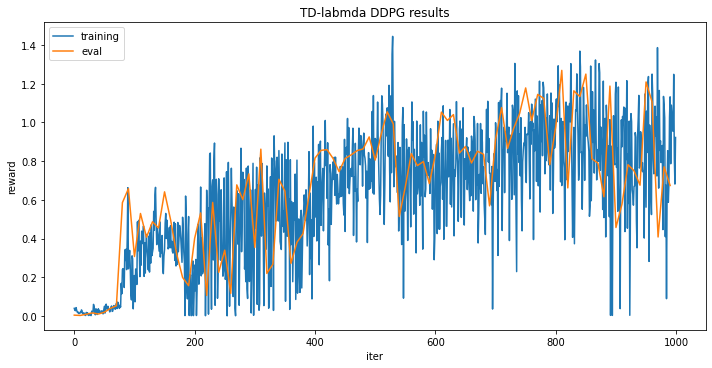

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*rewards), label="training")
plt.plot(*zip(*rewards_eval), label="eval")
plt.legend()
plt.xlabel("iter")
plt.ylabel("reward")
plt.tight_layout()
plt.title("TD-labmda DDPG results")